In [ ]:
def headway(x_im1: float, x_i: float, L: float) -> float:
    """
    Compute the headway Δx_i on a circular track of length L.  
    Δx_i is defined as the forward distance from vehicle i at position x_i  
    to its leader at position x_{i-1}, taking into account periodic  
    wrap-around boundary conditions on the ring.

    In the Jiang & Wu model, for vehicle i following vehicle i-1:
    
        Δx_i = (x_{i-1} - x_i) mod L

    Args:
        x_im1 (float): x_{i-1}, the longitudinal position of car i-1 along the ring, in [0, L).
        x_i   (float): x_i,   the longitudinal position of car i   along the ring, in [0, L).
        L     (float): Total length (circumference) of the circular track.

    Returns:
        float: Δx_i ∈ [0, L), the forward gap from car i to car i-1, computed with wrap-around.

    Notes:
        • Correctly handles the case when the leader wraps past position L back to 0.  
        • Always returns a non-negative gap less than the ring length.  
        • This Δx_i is used as input to the optimal-velocity function V(Δx).

    Examples:
        >>> headway(x_im1=10.0, x_i=8.0, L=100.0)
        2.0
        >>> headway(x_im1=2.0,  x_i=98.0, L=100.0)
        4.0
    """
    return (x_im1 - x_i) % L

In [ ]:
import numpy as np

# Parameters from Jiang & Wu (2007)
x_c, x_c1, x_c2 = 2.0, 3.2, 4.0
a, b = 5.0, 1.0

def V(dx: float) -> float:
    """
    Compute the optimal-velocity V(Δx) as defined in Eq. (2) of Jiang & Wu (2007).

    V(Δx) is the desired speed given the headway Δx, capturing three driving regimes:
      1. **Low gap**: drivers use their own headlights, yielding a shifted tanh profile.
      2. **Medium gap**: drivers “borrow” visibility from the car ahead, with speed = a - Δx.
      3. **High gap**: visibility is ample, so speed is capped at a constant b.

    In the Jiang & Wu model:
        V(Δx) = 
            tanh(Δx - x_c) + tanh(x_c),   if Δx < x_c1,
            a - Δx,                       if x_c1 ≤ Δx < x_c2,
            b,                            if Δx ≥ x_c2.

    Args:
        dx (float): Headway Δx between the following vehicle and its leader.

    Returns:
        float: Desired velocity V(Δx) according to the night-driving model.

    Notes:
        • Typical parameter values are:
            x_c  = 2.0, 
            x_c1 = 3.2, 
            x_c2 = 4.0, 
            a    = 5.0, 
            b    = 1.0.
        • This piecewise function is continuous at Δx = x_c1 and Δx = x_c2.

    Examples:
        >>> V(1.0)
        np.tanh(1.0 - 2.0) + np.tanh(2.0)
        >>> V(3.5)
        5.0 - 3.5
        >>> V(5.0)
        1.0
    """
    if dx < x_c1:
        return np.tanh(dx - x_c) + np.tanh(x_c)
    elif dx < x_c2:
        return a - dx
    else:
        return b

In [ ]:
def acceleration(v_i: float, v_im1: float, Δx_i: float, κ: float, λ: float) -> float:
    """
    Compute the acceleration dv_i/dt of vehicle i according to the full velocity difference (FVD) model.

    The model reads:
        dv_i/dt = κ [ V(Δx_i) - v_i ] + λ [ v_{i-1} - v_i ]

    where
      • v_i     is the speed of vehicle i,
      • v_{i-1} is the speed of its leader (vehicle i-1),
      • Δx_i    is the headway = (x_{i-1} - x_i) mod L,
      • V(Δx_i) is the optimal-velocity function (Eq. (2)),
      • κ       is the sensitivity to the optimal-velocity term,
      • λ       is the sensitivity to the leader-follower speed difference.

    Args:
        v_i (float):
            v_i, the current speed of vehicle i.
        v_im1 (float):
            v_{i-1}, the current speed of the leading vehicle.
        Δx_i (float):
            Δx_i = (x_{i-1} - x_i) mod L, the headway gap.
        κ (float):
            Sensitivity parameter κ for the term [V(Δx_i) - v_i].
        λ (float):
            Sensitivity parameter λ for the term [v_{i-1} - v_i].

    Returns:
        float:
            dv_i/dt, the instantaneous acceleration of vehicle i.  
            Positive values → speeding up; negative → braking.

    Notes:
      • This function depends on V(Δx_i), which must be implemented separately
        as the piecewise optimal-velocity law (Eq. (2)).  
      • Together with an Euler update
            v_i(t+Δt) = v_i(t) + (dv_i/dt)·Δt
        this drives the time evolution of speeds in the simulation.

    Examples:
        >>> # Given v_i=1.0, leader v_{i-1}=1.2, headway Δx_i=3.5, κ=1.0, λ=0.5
        >>> accel = acceleration(1.0, 1.2, 3.5, 1.0, 0.5)
        >>> print(f"{accel:.3f}")
    """
    return κ * (V(Δx_i) - v_i) + λ * (v_im1 - v_i)

In [4]:
import numpy as np

def euler_step(x: np.ndarray,
               v: np.ndarray,
               kappa: float,
               lambda_: float,
               dt: float,
               L: float,
               A: float = 0.0) -> tuple[np.ndarray, np.ndarray]:
    """
    Advance N vehicles by one time step dt using the FVD model and the
    second-order update from Jiang & Wu (2007), Eqs. (3)-(4), with optional per-step noise.

    Parameters
    ----------
    x       : np.ndarray, shape (N,)
              positions x_i(t) in [0, L)
    v       : np.ndarray, shape (N,)
              speeds v_i(t)
    kappa   : float
              sensitivity to the optimal-velocity term
    lambda_ : float
              sensitivity to the leader-follower speed difference
    dt      : float
              time step dt
    L       : float
              ring length
    A       : float, default 0.0
              noise amplitude; at each step add uniform random in [-A/2, +A/2] to each v_i

    Returns
    -------
    x_next  : np.ndarray, shape (N,)
              updated positions x_i(t+dt) mod L
    v_next  : np.ndarray, shape (N,)
              updated speeds v_i(t+dt)

    Notes
    -----
    1) Compute headways:
           dx_i = (x_{i-1} - x_i) mod L
    2) Compute acceleration:
           dv_i/dt = kappa * [V(dx_i) - v_i] + lambda_ * [v_{i-1} - v_i]
    3) Update speed:
           v_next = v + (dv_i/dt) * dt
    4) Inject noise:
           if A > 0:
               v_next += (np.random.rand(N) - 0.5) * A
    5) Update position:
           x_next = x + v * dt + 0.5 * (dv_i/dt) * dt * dt  (mod L)
    """
    # 1) headways
    dx = (np.roll(x, 1) - x) % L

    # 2) acceleration
    V_dx = np.array([V(d) for d in dx])
    dv_dt = kappa * (V_dx - v) + lambda_ * (np.roll(v, 1) - v)

    # 3) speed update
    v_next = v + dv_dt * dt

    # 4) noise
    if A > 0.0:
        N = v.shape[0]
        v_next += (np.random.rand(N) - 0.5) * A

    # 5) position update
    x_next = (x + v * dt + 0.5 * dv_dt * dt * dt) % L

    return x_next, v_next

In [5]:
import numpy as np

def initialize_uniform_flow(N: int, L: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Initialize N vehicles in uniform flow on a ring of length L.

    In the Jiang & Wu model, the uniform initial state is:
        x_i(0) = i * L / N
        v_i(0) = V(L / N)

    Args:
        N (int):   Number of vehicles.
        L (float): Total length (circumference) of the circular track.

    Returns:
        tuple[np.ndarray, np.ndarray]:
        - x (np.ndarray): Array of shape (N,) containing initial positions x_i(0),
                          evenly spaced in [0, L).
        - v (np.ndarray): Array of shape (N,) containing initial speeds v_i(0),
                          all equal to V(L/N).

    Notes:
        • Uses the optimal‐velocity function V(·) to compute the uniform speed.
        • Positions are generated with numpy.linspace to ensure exact spacing.
    """
    x = np.linspace(0, L, N, endpoint=False)
    v0 = V(L / N)
    v = np.full(N, v0)
    return x, v

In [20]:
# 1) Simulation parameters
N        = 120       # number of vehicles
L        = 500.0    # ring length
kappa    = 1.0      # sensitivity to optimal‐velocity term
lambda_  = 0.5      # sensitivity to speed‐difference term
dt       = 0.1      # time step Δt
T        = 500.0    # total simulation time
steps    = int(T / dt)
A        = 0.0      # noise amplitude (set >0 for stochastic runs)

# 2) Initialize uniform flow (or apply perturbation here)
x, v = initialize_uniform_flow(N, L)
# e.g. to apply a small brake on car 0 by ε=0.1:
# v[0] = max(0.0, v[0] - 0.1)

# 3) Pre‐allocate storage for trajectories and speeds
traj   = np.zeros((steps, N))   # positions
speeds = np.zeros((steps, N))   # speeds

# 4) Main time‐stepping loop
for t in range(steps):
    # Record current state
    traj[t]   = x
    speeds[t] = v

    # Advance one step using the FVD Euler integrator
    x, v = euler_step(x, v, kappa, lambda_, dt, L, A)

# After this loop, `traj[t,i]` is x_i at time t·dt,
# and `speeds[t,i]` is v_i at time t·dt.

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def plot_space_time_raster(traj: np.ndarray,
                           *,
                           dt: float = T,
                           L: float = L,
                           s: int = 1,
                           color: str = 'gray',
                           alpha: float = 0.2,
                           figsize: tuple = (10, 6)
                          ) -> tuple[plt.Figure, plt.Axes]:
    """
    Plot a space–time raster diagram of vehicle positions on a circular track.

    Parameters
    ----------
    traj : np.ndarray, shape (steps, N)
        traj[t, i] is the position of vehicle i at time t*dt.
    dt : float
        Time increment between successive rows in traj.
    L : float
        Total length (circumference) of the ring; sets the y-axis limits.
    s : int, optional
        Marker size for scatter points (default is 1).
    color : str, optional
        Marker color (default is 'gray').
    alpha : float, optional
        Marker opacity in [0, 1] (default is 0.2).
    figsize : tuple, optional
        Figure size in inches as (width, height) (default is (10, 6)).

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object containing the raster plot.
    ax : matplotlib.axes.Axes
        The axes object of the raster plot.

    Notes
    -----
    - Uses plt.scatter with rasterization to handle large point counts efficiently.
    - X-axis runs from 0 to total time = steps * dt.
    - Y-axis runs from 0 to L (ring length).
    - Light color and low alpha reveal high-density overlaps without saturating to black.
    """
    steps, N = traj.shape
    t = np.arange(steps) * dt

    fig, ax = plt.subplots(figsize=figsize)
    for i in range(N):
        ax.scatter(
            t,
            traj[:, i],
            s=s,
            color=color,
            alpha=alpha,
            rasterized=True
        )

    ax.set_xlabel('Time')
    ax.set_ylabel('Position on ring')
    ax.set_title('Space–time raster plot of vehicle positions')
    ax.set_xlim(0, steps * dt)
    ax.set_ylim(0, L)
    fig.tight_layout()

    return fig, ax


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Space–time raster plot of vehicle positions'}, xlabel='Time', ylabel='Position on ring'>)

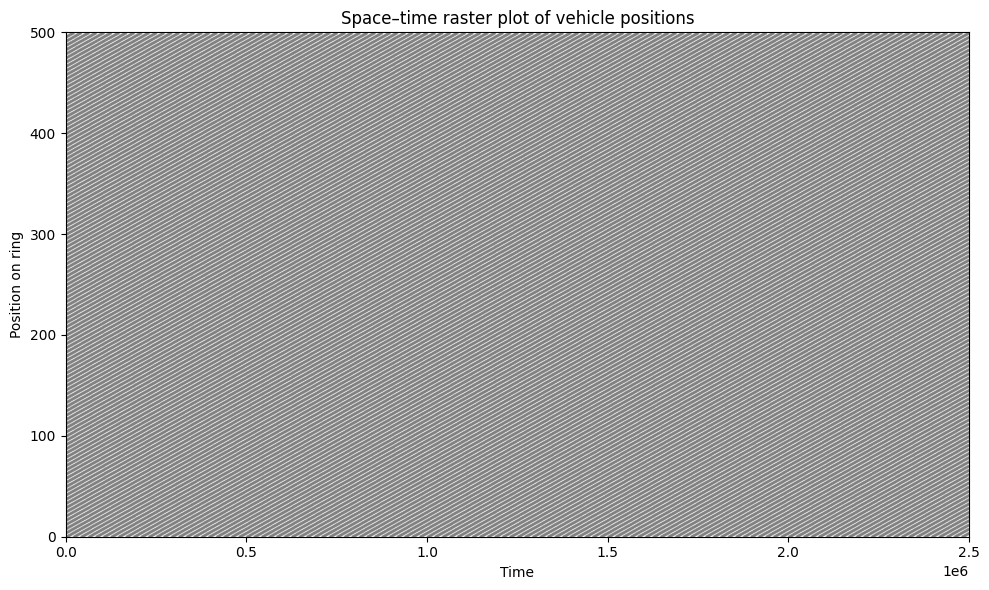

In [29]:
plot_space_time_raster(traj=traj)